# Dense Model for Kinect data


## Section for Configurations and Imports

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
random_state = 47
np.random.seed(random_state)

In [5]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True)

## 1. Load Prepared Dataset

In [6]:
data_path = '../../datasets/exercise_score/'
train_files = [
    'kinect_train_dataset_1.csv',
    'kinect_train_dataset_2.csv',
    'kinect_train_dataset_3.csv',
    'kinect_train_dataset_4.csv',
    'kinect_train_dataset_5.csv',
]

test_files = [
    'kinect_test_dataset_1.csv',
    'kinect_test_dataset_2.csv',
    'kinect_test_dataset_3.csv',
]
df_train = None
df_test = None

In [7]:
for file in train_files:
    try:
        dataset_train = pd.read_csv(data_path + file)
        if df_train is None:
            df_train = dataset_train
        else:
            df_train = df_train.append(dataset_train, ignore_index=True)  
    except IOError as e:
        print('Error in reading file: ', e)
print(df_train.shape, '\n')
print(df_train.head())

(895495, 40) 

     head_x   head_y    head_z  left_shoulder_x  left_shoulder_y  \
0  0.014747  0.75019  0.018200         -0.15129          0.45769   
1  0.014747  0.75019  0.018200         -0.15129          0.45769   
2  0.014747  0.75019  0.018200         -0.15129          0.45769   
3  0.014747  0.75019  0.018200         -0.15129          0.45769   
4  0.015055  0.75015  0.018535         -0.15084          0.45749   

   left_shoulder_z  left_elbow_x  left_elbow_y  left_elbow_z  \
0         0.016585      -0.18173       0.19971      0.034093   
1         0.016585      -0.18173       0.19971      0.034093   
2         0.016585      -0.18173       0.19971      0.034093   
3         0.016585      -0.18173       0.19971      0.034093   
4         0.017340      -0.18173       0.19967      0.034144   

   right_shoulder_x  ...  right_knee_x  right_knee_y  right_knee_z  \
0           0.16628  ...       0.12415      -0.41084     -0.025178   
1           0.16628  ...       0.12415      -0.4108

In [8]:
for file in test_files:
    try:
        dataset_test = pd.read_csv(data_path + file)
        if df_test is None:
            df_test = dataset_test
        else:
            df_test = df_test.append(dataset_test, ignore_index=True)  
    except IOError as e:
        print('Error in reading file: ', e)
print(df_test.shape, '\n')
print(df_test.head())

(106134, 40) 

     head_x   head_y    head_z  left_shoulder_x  left_shoulder_y  \
0 -0.000956  0.70872  0.004201         -0.17179          0.48246   
1 -0.000956  0.70872  0.004201         -0.17179          0.48246   
2 -0.000956  0.70872  0.004201         -0.17179          0.48246   
3 -0.000956  0.70872  0.004201         -0.17179          0.48246   
4 -0.000983  0.70887  0.004283         -0.17177          0.48234   

   left_shoulder_z  left_elbow_x  left_elbow_y  left_elbow_z  \
0         0.037272      -0.35875       0.62571      0.059937   
1         0.037272      -0.35875       0.62571      0.059937   
2         0.037272      -0.35875       0.62571      0.059937   
3         0.037272      -0.35875       0.62571      0.059937   
4         0.035379      -0.35855       0.62601      0.059772   

   right_shoulder_x  ...  right_knee_x  right_knee_y  right_knee_z  \
0           0.15655  ...       0.11736      -0.45209     -0.018903   
1           0.15655  ...       0.11736      -0.4520

In [9]:
X_train = df_train.drop(columns=['ExreciseScore'])
y_train = df_train[['ExreciseScore']]

In [10]:
X_test = df_test.drop(columns=['ExreciseScore'])
y_test = df_test[['ExreciseScore']]

In [11]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

In [12]:
#input_mean_train = X_train.mean()
#input_std_train = X_train.std()

#X_train = (X_train - input_mean_train) / input_std_train

#X_train.to_numpy()

In [13]:
#input_mean_test = X_test.mean()
#input_std_test = X_test.std()

#X_test = (X_test - input_mean_test) / input_std_test

#X_test.to_numpy()

In [14]:
#output_mean_train = y_train.mean()
#output_std_train = y_train.std()

#y_train = (y_train - output_mean_train) / output_std_train

#y_train.to_numpy()

In [15]:
print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (895495, 39)
Training labels shape: (895495, 1) 

Test features shape: (106134, 39)
Test labels shape: (106134, 1)


## 3. Define the Model

### 3.1 Configurations

In [16]:
EPOCHS = 500
BATCH_SIZE = 150

input_dim = X_train.shape[1]
output_size = 1

activation = 'relu'
#kernel_initializer = 'he_uniform'
kernel_initializer = 'normal'
#output_activation = 'sigmoid'
output_activation = 'linear'

#optimizer = 'SGD'
#optimizer = 'RMSprop'
optimizer = 'Adam'
#learning_rate = 1e-1
#learning_rate = 1e-2
learning_rate = 1e-3
#learning_rate = 1e-4

### 3.2 Model Architecture

In [17]:
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

METRICS = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def make_model(input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS):
    #MODEL 3 - Champ
    #model = Sequential()
    #model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    
    #MODEL 2
    #model = Sequential()
    #model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    
    #MODEL 1
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(output_size, activation=output_activation))
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Configurations

In [18]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_z"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_z"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_z"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_z"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_z"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "left_hand_z"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "right_hand_z"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_z"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_z"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_z"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_z"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "left_foot_z"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
    ColSpec("double", "right_foot_z"),
])
output_schema = Schema([
    ColSpec("double", "ExreciseScore"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

### 4.2 Helper functions

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

### 4.3 Start Run

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 9,073
Trainable params: 9,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
4776/4776 [==============================] - 6s 1ms/step - loss: 0.4441 - mse: 0.4441 - mae: 0.5035 - r

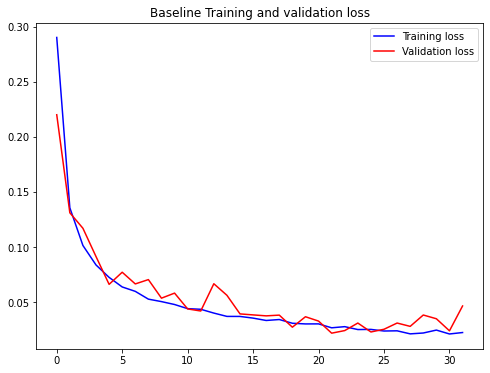

<Figure size 576x432 with 0 Axes>

708/708 [==============================] - 0s 418us/step
INFO:tensorflow:Assets written to: /var/folders/8b/c37c7tv54lg10kt29r67dkh80000gn/T/tmpk9dhwv9d/model/data/model/assets
MSE:  0.8113017928030362
MAE:  0.617102767931264
R-Squared:  0.6038949984419832
Explained Variance Score:  0.6078459066171573


In [21]:
model_name = 'dense_model_kinect_ExreciseScore'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        loss='mean_squared_error', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        input_dim=input_dim)
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping])

    # Plot training history
    plot_train_history(history, 'Baseline Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()
    
    # Log model, scaler, model parameters to MLflow
    mlflow.log_param("activation", activation)
    mlflow.log_param("kernel_initializer", kernel_initializer)
    mlflow.log_param("output activation", output_activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("batch size", BATCH_SIZE)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
        
    #mlflow.log_param("input_mean_train", input_mean_train)
    #mlflow.log_param("input_std_train", input_std_train)
    #mlflow.log_param("input_mean_test", input_mean_test)
    #mlflow.log_param("input_std_test", input_std_test)
    #mlflow.log_param("output_mean", output_mean)
    #mlflow.log_param("output_std", output_std)

    # Log model performance
    process_time = [None] * 10
    
    for i in range(10):
        start_time = time.time()
        predictions = model.predict(X_test)
        end_time = time.time()
        process_time[i] = (end_time - start_time) * 1000
    
    #predictions = (predictions * output_std_train.to_numpy()) + output_mean_train.to_numpy()
    
    #output_mean_test = y_test.mean()
    #output_std_test = y_test.std()
    #y_test = (y_test - output_mean_test) / output_std_test
    #y_test.to_numpy()
    
    #(mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    
    predictions = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
    predictions = y_scaler.inverse_transform(predictions)
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_param("total params", model.count_params())
    mlflow.log_metric("process time", np.mean(process_time)) 
    
    mlflow.keras.log_model(model, model_name, signature=signature)

    # Print metrics
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

## 5. Register Model

In [22]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Registered model 'dense_model_kinect_ExreciseScore' already exists. Creating a new version of this model...
2021/06/01 20:55:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dense_model_kinect_ExreciseScore, version 12


Name: dense_model_kinect_ExreciseScore
Version: 12


Created version '12' of model 'dense_model_kinect_ExreciseScore'.
